In [15]:
from engine.predictor import DefaultPredictor
from config.config import get_cfg
from model.rcnn import GeneralizedRCNN
import torch
import cv2
import matplotlib.pyplot as plt
from data.pascal_voc import VOC_CLASS_NAMES
import copy
# from utils.visualizer import Visualizer
from data.catalog import MetadataCatalog, DatasetCatalog

print(torch.cuda.device_count())
torch.cuda.set_device(2)
print(torch.cuda.current_device())

4
2


In [17]:
cfg = get_cfg()
cfg.MODEL.ROI_HEADS.NUM_CLASSES  = 21
cfg.MODEL.RPN.USE_MDN = False
model = GeneralizedRCNN(cfg).to('cuda')
cfg.MODEL.ROI_HEADS.AUTO_LABEL = True
state_dict = torch.load('./ckpt/baseline/base_17500.pt')
model.load_state_dict(state_dict)
predictor = DefaultPredictor(cfg,model)
VOC_CLASS_NAMES = (*VOC_CLASS_NAMES, 'unknown')

/data/private/faster_rcnn_rilab/model/rpn/rpn.py:39: UserWarning: nn.init.normal is now deprecated in favor of nn.init.normal_.
  nn.init.normal(layers.weight,std=0.01)
/data/private/faster_rcnn_rilab/model/rpn/rpn.py:40: UserWarning: nn.init.normal is now deprecated in favor of nn.init.normal_.
  nn.init.normal(layers.bias,0)


## Inference

In [18]:
img = cv2.imread('input.png')


In [19]:
pred = predictor(img)
pred = pred['instances']._fields

In [20]:
pred_boxes = pred['pred_boxes']
scores = pred['scores']
pred_classes = pred['pred_classes']
print(pred_classes)
index = torch.where(scores>0.5)[0]

top_pred_boxes = pred_boxes[index]
top_pred_classes = pred_classes[index]

tensor([12, 14, 14, 14, 14, 14, 14, 14,  2, 20, 16,  4, 12, 14, 12, 20, 14, 12,
         9, 14, 16, 20, 11,  4,  9, 20, 11,  9, 12, 20,  8, 20, 14, 20,  7,  8,
        14, 14, 20, 14, 12,  8, 12, 14, 14, 14, 14, 14, 14, 14, 20, 14, 12,  2,
        14, 12, 14, 20, 20, 14,  2], device='cuda:2')


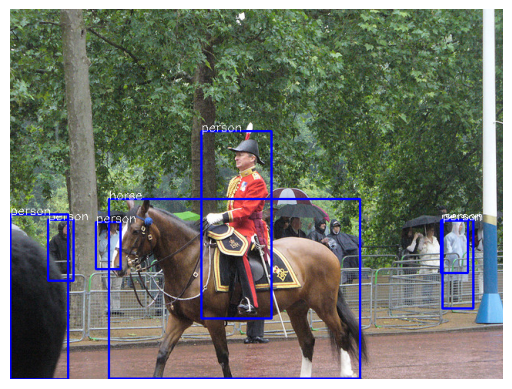

In [21]:
demo_image = copy.deepcopy(img)
for bbox,label in zip(top_pred_boxes,top_pred_classes):
    cv2.rectangle(demo_image, (int(bbox[0]), int(bbox[1])), 
                        (int(bbox[2]),int(bbox[3])), (255, 0, 0), 2)
    cv2.putText(demo_image, VOC_CLASS_NAMES[int(label)], 
                            (int(bbox[0]), int(bbox[1])),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 1)
demo_image = cv2.cvtColor(demo_image, cv2.COLOR_RGB2BGR)
plt.imshow(demo_image)
plt.axis('off')
plt.show()

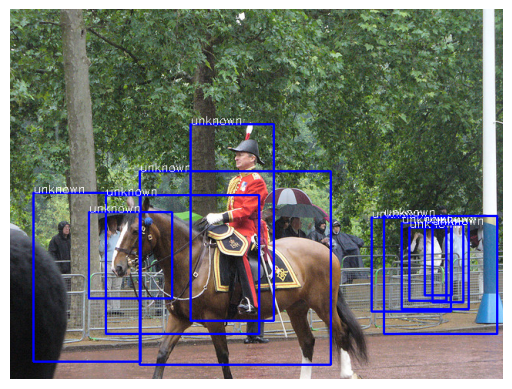

In [22]:
index = torch.where(pred_classes==20)[0]
unk_pred_boxes = pred_boxes[index]
unk_pred_classes = pred_classes[index]

demo_image = copy.deepcopy(img)
for bbox,label in zip(unk_pred_boxes,unk_pred_classes):
    cv2.rectangle(demo_image, (int(bbox[0]), int(bbox[1])), 
                        (int(bbox[2]),int(bbox[3])), (255, 0, 0), 2)
    cv2.putText(demo_image, VOC_CLASS_NAMES[int(label)], 
                            (int(bbox[0]), int(bbox[1])),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 1)
demo_image = cv2.cvtColor(demo_image, cv2.COLOR_RGB2BGR)
plt.imshow(demo_image)
plt.axis('off')
plt.show()

## RPN

In [8]:
pred = predictor.proposal_predict(img)[0]
pred = pred['instances']._fields
proposal_boxes = pred['proposal_boxes'].tensor
objectness = pred['objectness_logits']
objectness = torch.sigmoid(objectness)
print(proposal_boxes.shape)
index = torch.where(objectness>0.2)[0]

proposal_boxes = proposal_boxes[index]

torch.Size([18, 4])


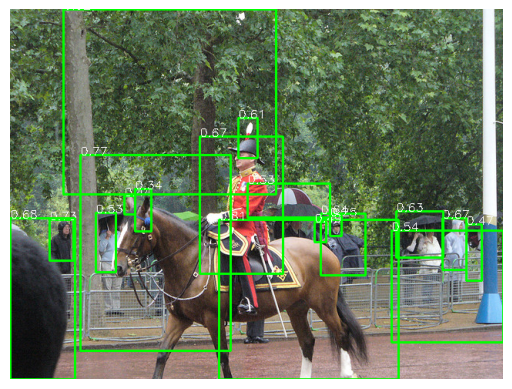

In [9]:
demo_image = copy.deepcopy(img)
for bbox,score in zip(proposal_boxes,objectness):
    cv2.rectangle(demo_image, (int(bbox[0]), int(bbox[1])), 
                        (int(bbox[2]),int(bbox[3])), (0, 255, 0), 2)
    cv2.putText(demo_image, str(round(score.item(),2)), 
                            (int(bbox[0]), int(bbox[1])),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 1)
demo_image = cv2.cvtColor(demo_image, cv2.COLOR_RGB2BGR)
plt.imshow(demo_image)
plt.axis('off')
plt.show()

## Uncertainty

In [10]:
pred = predictor.uncertainty_predict(img)[0]
pred = pred['instances']._fields

In [11]:
proposal_boxes = pred['proposal_boxes'].tensor
epis = pred['epis']
alea = pred['alea']
print(epis.shape,proposal_boxes.shape)

torch.Size([18]) torch.Size([18, 4])


In [12]:
min_epis = torch.min(epis).item()
max_epis = torch.max(epis).item()

min_alea = torch.min(alea).item()
max_alea = torch.max(alea).item()

def scale(e,a):
    return (e-min_epis)/(max_epis-min_epis),(a-min_alea)/(max_alea-min_alea)

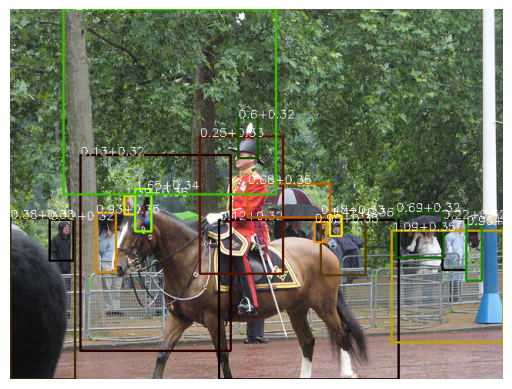

In [13]:
demo_image = copy.deepcopy(img)
for bbox,e,a in zip(proposal_boxes,epis,alea):
    e = e.item()
    a = a.item()
    se,sa = scale(e,a)
    cv2.rectangle(demo_image, (int(bbox[0]), int(bbox[1])), 
                        (int(bbox[2]),int(bbox[3])), (0, int(255*se), int(255*sa)), 2)
    cv2.putText(demo_image, str(round(e,2))+'+' +str(round(a,2)), 
                            (int(bbox[0]), int(bbox[1])),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 1)
demo_image = cv2.cvtColor(demo_image, cv2.COLOR_RGB2BGR)
plt.imshow(demo_image)
plt.axis('off')
plt.show()

In [14]:
print(alea)
print(epis)

tensor([0.3201, 0.3243, 0.3173, 0.3278, 0.3316, 0.3205, 0.3327, 0.3205, 0.3205,
        0.3489, 0.3498, 0.3517, 0.3550, 0.3221, 0.3590, 0.3383, 0.3274, 0.3596],
       device='cuda:2')
tensor([0.1190, 0.1268, 0.1204, 0.3802, 0.2492, 0.2242, 0.4750, 0.6856, 0.5998,
        1.0861, 0.6779, 0.9316, 0.9501, 0.9469, 1.3898, 1.6475, 1.2625, 1.4168],
       device='cuda:2')
